In [1]:
import torch
import torchvision
from torchvision import datasets,transforms
import os
import matplotlib.pyplot as plt
import time
from torch.autograd import Variable
%matplotlib inline

In [2]:
data_dir = '/home/msy/AI_dataset'
data_transform = {x:transforms.Compose([transforms.Resize([64,64]),
                                      transforms.ToTensor()])
                  for x in ["train","valid"]}

In [3]:
image_datasets = {x:datasets.ImageFolder(root = os.path.join(data_dir,x),
                                        transform=data_transform[x])
                for x in ["train","valid"]}
dataloader = {x:torch.utils.data.DataLoader(dataset=image_datasets[x],
                                           batch_size=16,
                                           shuffle=True)
                for x in ["train","valid"]}

In [4]:
x_example,y_example=next(iter(dataloader["train"]))

In [5]:
x_example.size()

torch.Size([16, 3, 64, 64])

In [6]:
y_example.size()

torch.Size([16])

In [7]:
index_classes=image_datasets["train"].class_to_idx
print(index_classes)

{'Cat': 0, 'Dog': 1}


In [8]:
example_classes=image_datasets["train"].classes
print(example_classes)

['Cat', 'Dog']


['Cat', 'Cat', 'Cat', 'Dog', 'Dog', 'Dog', 'Dog', 'Dog', 'Cat', 'Dog', 'Dog', 'Dog', 'Dog', 'Dog', 'Cat', 'Dog']


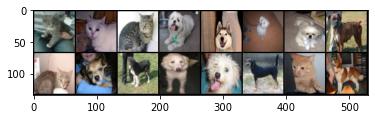

In [9]:
img=torchvision.utils.make_grid(x_example)
img=img.numpy().transpose([1,2,0])
print([example_classes[i] for i in y_example])
plt.imshow(img)
plt.show()

In [10]:
#新的输出图像大小 = (n + 2p - f)/s + 1  
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.Conv=torch.nn.Sequential(
                torch.nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1),  #3个通道rgb，各有自己的卷积核，每次3个核卷积的结果(3个值)都会求和,
                torch.nn.ReLU(),                                         #即3通道融合为1通道，作为后面节点中的一个值，共输出64个节点
                torch.nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1), #64
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=2,stride=2),              #32

                torch.nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=2,stride=2),              #16

                torch.nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=2,stride=2),             #8

                torch.nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=2,stride=2)              #4
        )
        self.Classes=torch.nn.Sequential(
                torch.nn.Linear(4*4*512,1024),
                torch.nn.ReLU(),
                torch.nn.Dropout(p=0.5),
                torch.nn.Linear(1024,1024),
                torch.nn.ReLU(),
                torch.nn.Dropout(p=0.5),
                torch.nn.Linear(1024,2)
        )
        
    def forward(self,input):
        x=self.Conv(input)
        x=x.view(-1,4*4*512)
        x=self.Classes(x)
        return x
    

In [11]:
model=Model()
print(model)

Model(
  (Conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), paddi

In [12]:
loss_f=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.00001)

In [15]:
Use_gpu=1

In [17]:
if Use_gpu:
    model=model.cuda()
epoch_n=10
time_open=time.time()

for epoch in range(epoch_n):
    print("Epoch{}/{}".format(epoch,epoch_n-1))
    print("-"*10)
    
    for phase in ["train","valid"]:
        if phase =="train":
            print("Training...")
            model.train(True)
        else:
            print("Validing...")
            model.train(False)
        
        running_loss=0.0
        running_corrects=0
        
        for batch,data in enumerate(dataloader[phase],1):
            x,y=data
            if Use_gpu:
                x,y=Variable(x.cuda()),Variable(y.cuda()) #gpu的运算类型
            else:
                x,y=Variable(x),Variable(y) #cpu的运算类型
             
            y_pred=model(x) #输出预测y
            
            _,pred=torch.max(y_pred.data,1) #限幅
            
            optimizer.zero_grad()
            
            loss=loss_f(y_pred,y)#loss function
            
            if phase == "train":
                loss.backward() #backproperganda
                optimizer.step()  #??????????????????????????
                
            running_loss+=loss.data
            running_corrects+=torch.sum(pred==y.data) #预测值与样本值相等
            
            if batch%500 == 0 and phase =="train":
                print("Batch{},Train Loss:{:.4f},Train ACC:{:.4f}".format(batch,running_loss/batch,100*running_corrects/(16*batch)))
            
        epoch_loss = running_loss*16/len(image_datasets[phase])
        epoch_acc = 100*running_corrects/len(image_datasets[phase])
        
        print("{}Loss:{:.4f} Acc:{:.4f}%".format(phase,epoch_loss,epoch_acc))
    time_end=time.time()-time_open
    print(time_end)

Epoch0/9
----------
Training...


/opt/conda/conda-bld/pytorch_1591914880026/work/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


Batch500,Train Loss:0.6934,Train ACC:49.0000
Batch1000,Train Loss:0.6917,Train ACC:51.0000


/home/msy/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/home/msy/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/home/msy/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/home/msy/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/home/msy/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:766: UserWarning: Possibly corrupt E

trainLoss:0.6896 Acc:52.0000%
Validing...
validLoss:0.6884 Acc:54.0000%
461.72965121269226
Epoch1/9
----------
Training...
Batch500,Train Loss:0.6828,Train ACC:56.0000
Batch1000,Train Loss:0.6782,Train ACC:57.0000
trainLoss:0.6760 Acc:57.0000%
Validing...
validLoss:0.6648 Acc:59.0000%
777.8250708580017
Epoch2/9
----------
Training...
Batch500,Train Loss:0.6632,Train ACC:59.0000
Batch1000,Train Loss:0.6582,Train ACC:61.0000
trainLoss:0.6565 Acc:61.0000%
Validing...
validLoss:0.6598 Acc:59.0000%
1088.750752210617
Epoch3/9
----------
Training...
Batch500,Train Loss:0.6383,Train ACC:64.0000
Batch1000,Train Loss:0.6372,Train ACC:64.0000
trainLoss:0.6369 Acc:64.0000%
Validing...
validLoss:0.6228 Acc:64.0000%
1419.6479082107544
Epoch4/9
----------
Training...
Batch500,Train Loss:0.6245,Train ACC:65.0000
Batch1000,Train Loss:0.6230,Train ACC:65.0000
trainLoss:0.6230 Acc:65.0000%
Validing...
validLoss:0.6124 Acc:66.0000%
1740.7235043048859
Epoch5/9
----------
Training...
Batch500,Train Loss:0.6